In [ ]:
!wget -r -N -c -np https://physionet.org/files/bidmc/1.0.0/

In [ ]:
!pip install wfdb

In [ ]:
"""import numpy as np
import pandas as pd
import os
import wfdb
from scipy import signal
import matplotlib.pyplot as plt
import scipy.stats
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, Matern, ConstantKernel
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split

# Install wfdb if not already installed
try:
    import wfdb
except ImportError:
    !pip install wfdb

# Path to the BIDMC dataset
bidmc_path = "/content/physionet.org/files/bidmc/1.0.0/"

# List all patient files
patient_ids = []
for file in os.listdir(bidmc_path):
    if file.startswith("bidmc") and file.endswith(".hea") and not file.endswith("n.hea"):
        patient_id = file.replace("bidmc", "").replace(".hea", "")
        patient_ids.append(patient_id)

print(f"Found {len(patient_ids)} patient records")

# Load all patient data
all_ppg_data = []
all_resp_data = []
all_ecg_data = []
all_rr_values = []
all_spo2_values = []

for patient_id in patient_ids:
    try:
        # Load waveform data (PPG, ECG, resp)
        waveform_path = os.path.join(bidmc_path, f"bidmc{patient_id}")
        record = wfdb.rdrecord(waveform_path)

        # Get signal indices based on the record.sig_name
        ppg_idx = [i for i, name in enumerate(record.sig_name) if 'PLETH' in name]
        ecg_idx = [i for i, name in enumerate(record.sig_name) if 'II' in name]  # Lead II ECG
        resp_idx = [i for i, name in enumerate(record.sig_name) if 'RESP' in name]

        if ppg_idx and resp_idx:  # Make sure we have the signals we need
            ppg_signal = record.p_signal[:, ppg_idx[0]]
            resp_signal = record.p_signal[:, resp_idx[0]]
            ecg_signal = record.p_signal[:, ecg_idx[0]] if ecg_idx else None

            # Load numerics data (RR, SpO2)
            numerics_path = os.path.join(bidmc_path, f"bidmc{patient_id}n")
            numerics = wfdb.rdrecord(numerics_path)

            # Get numeric indices
            rr_idx = [i for i, name in enumerate(numerics.sig_name) if 'RESP' in name]
            spo2_idx = [i for i, name in enumerate(numerics.sig_name) if 'SpO2' in name]

            if rr_idx and spo2_idx:
                rr_values = numerics.p_signal[:, rr_idx[0]]
                spo2_values = numerics.p_signal[:, spo2_idx[0]]

                # Store data
                all_ppg_data.append(ppg_signal)
                all_resp_data.append(resp_signal)
                if ecg_signal is not None:
                    all_ecg_data.append(ecg_signal)
                all_rr_values.append(rr_values)
                all_spo2_values.append(spo2_values)

                print(f"Loaded data for patient {patient_id}")

    except Exception as e:
        print(f"Error loading data for patient {patient_id}: {e}")

print(f"Successfully loaded data for {len(all_ppg_data)} patients")

# Step 1: Signal Preprocessing - Apply filters to reduce noise
def preprocess_signal(signal_data, fs=125, signal_type='ppg'):
    """
    Apply appropriate filters based on signal type
    """
    # Fill any potential NaN values
    signal_data = np.nan_to_num(signal_data)

    if signal_type == 'ppg':
        # Bandpass filter for PPG (0.5-8 Hz typical range)
        b, a = signal.butter(4, [0.5, 8], btype='bandpass', fs=fs)
        filtered = signal.filtfilt(b, a, signal_data)

    elif signal_type == 'ecg':
        # Bandpass filter for ECG (0.5-40 Hz typical range)
        b, a = signal.butter(4, [0.5, 40], btype='bandpass', fs=fs)
        filtered = signal.filtfilt(b, a, signal_data)

    elif signal_type == 'resp':
        # Bandpass filter for respiratory signals (0.05-1 Hz typical range)
        b, a = signal.butter(4, [0.05, 1], btype='bandpass', fs=fs)
        filtered = signal.filtfilt(b, a, signal_data)

    return filtered

# Apply filtering to all signals
all_ppg_filtered = [preprocess_signal(ppg, signal_type='ppg') for ppg in all_ppg_data]
all_resp_filtered = [preprocess_signal(resp, signal_type='resp') for resp in all_resp_data]
all_ecg_filtered = [preprocess_signal(ecg, signal_type='ecg') for ecg in all_ecg_data] if all_ecg_data else []

# Step 2: Feature extraction using 32-second windows
# Improved feature extraction function with better handling of extreme values
def extract_features_from_window(ppg_window, resp_window=None, ecg_window=None, fs=125):
    """Extract features from a window of signals with robust handling of outliers"""
    features = {}

    # Helper function to safely calculate statistics
    def safe_stat(data, func, default=0):
        try:
            result = func(data)
            return default if np.isinf(result) or np.isnan(result) else result
        except:
            return default

    # PPG features
    if ppg_window is not None:
        # Handle potential infinite values
        ppg_window = np.clip(ppg_window, -1e10, 1e10)

        # Time domain features
        features['ppg_mean'] = safe_stat(ppg_window, np.mean)
        features['ppg_std'] = safe_stat(ppg_window, np.std)
        features['ppg_skew'] = safe_stat(ppg_window, scipy.stats.skew)
        features['ppg_kurtosis'] = safe_stat(ppg_window, scipy.stats.kurtosis)

        # Peak detection
        try:
            peaks, _ = signal.find_peaks(ppg_window, distance=int(fs*0.5))
            if len(peaks) > 1:
                features['ppg_peak_distance_mean'] = safe_stat(np.diff(peaks), np.mean)
                features['ppg_peak_amplitude_mean'] = safe_stat(ppg_window[peaks], np.mean)
                features['ppg_peak_count'] = len(peaks)

                # Calculate peak-to-peak intervals
                peak_intervals = np.diff(peaks) / fs  # in seconds
                features['ppg_peak_interval_std'] = safe_stat(peak_intervals, np.std)
            else:
                features['ppg_peak_distance_mean'] = 0
                features['ppg_peak_amplitude_mean'] = 0
                features['ppg_peak_count'] = 0
                features['ppg_peak_interval_std'] = 0
        except:
            features['ppg_peak_distance_mean'] = 0
            features['ppg_peak_amplitude_mean'] = 0
            features['ppg_peak_count'] = 0
            features['ppg_peak_interval_std'] = 0

        # Frequency domain features
        try:
            f, pxx = signal.welch(ppg_window, fs=fs, nperseg=min(256, len(ppg_window)))
            if len(pxx) > 0:
                # Replace inf/nan values
                pxx = np.nan_to_num(pxx, nan=0.0, posinf=0.0, neginf=0.0)

                features['ppg_dominant_freq'] = f[np.argmax(pxx)] if np.max(pxx) > 0 else 0

                # Power in respiratory band (0.15-0.4 Hz)
                resp_band = (f >= 0.15) & (f <= 0.4)
                features['ppg_resp_power'] = np.sum(pxx[resp_band]) if np.any(resp_band) else 0

                # Power in cardiac band (0.5-2 Hz)
                cardiac_band = (f >= 0.5) & (f <= 2.0)
                features['ppg_cardiac_power'] = np.sum(pxx[cardiac_band]) if np.any(cardiac_band) else 0

                # Calculate ratio of respiratory to cardiac power
                cardiac_power = features['ppg_cardiac_power']
                features['ppg_resp_cardiac_ratio'] = (features['ppg_resp_power'] / cardiac_power
                                                     if cardiac_power > 0 else 0)
            else:
                features['ppg_dominant_freq'] = 0
                features['ppg_resp_power'] = 0
                features['ppg_cardiac_power'] = 0
                features['ppg_resp_cardiac_ratio'] = 0
        except:
            features['ppg_dominant_freq'] = 0
            features['ppg_resp_power'] = 0
            features['ppg_cardiac_power'] = 0
            features['ppg_resp_cardiac_ratio'] = 0

    # Add respiratory signal features if provided
    if resp_window is not None:
        # Add implementation for respiratory features here
        # Similar to PPG features but for respiratory signal
        pass

    # Add ECG signal features if provided
    if ecg_window is not None:
        # Add implementation for ECG features here
        # Similar to PPG features but for ECG signal
        pass

    return features

# Process all patients' data with sliding windows
window_size = 32 * 125  # 32 seconds at 125 Hz
step_size = 8 * 125     # 8 second step (75% overlap)

all_features = []
all_targets = []

for i in range(len(all_ppg_filtered)):
    ppg_signal = all_ppg_filtered[i]
    resp_signal = all_resp_filtered[i]
    ecg_signal = all_ecg_filtered[i] if i < len(all_ecg_filtered) else None

    # Get corresponding targets (downsample to match windows)
    rr_values = all_rr_values[i]
    spo2_values = all_spo2_values[i]

    # Process windows
    for start in range(0, len(ppg_signal) - window_size, step_size):
        end = start + window_size

        # Extract features from window
        ppg_window = ppg_signal[start:end]
        resp_window = resp_signal[start:end]
        ecg_window = ecg_signal[start:end] if ecg_signal is not None else None

        features = extract_features_from_window(ppg_window, resp_window, ecg_window)

        # Get target values (average over the window)
        # Convert window indices to the 1Hz numerics indices
        start_idx = start // 125
        end_idx = min(end // 125, len(rr_values))

        if end_idx > start_idx:
            # Calculate average but handle NaN values
            rr_window = rr_values[start_idx:end_idx]
            spo2_window = spo2_values[start_idx:end_idx]

            # Filter out NaN values before calculating mean
            rr_window_filtered = rr_window[~np.isnan(rr_window)]
            spo2_window_filtered = spo2_window[~np.isnan(spo2_window)]

            # Only use if we have valid values
            if len(rr_window_filtered) > 0 and len(spo2_window_filtered) > 0:
                rr_window_avg = np.mean(rr_window_filtered)
                spo2_window_avg = np.mean(spo2_window_filtered)

                # Add targets to features dict
                features['rr_target'] = rr_window_avg
                features['spo2_target'] = spo2_window_avg

                all_features.append(features)
                all_targets.append({'rr': rr_window_avg, 'spo2': spo2_window_avg})

# Convert to DataFrame
features_df = pd.DataFrame(all_features)
print(f"Extracted {len(features_df)} feature windows")
print(f"Features: {features_df.columns.tolist()}")

# NEW: Data quality checking function
def check_data_quality(X, y, name=""):
    """Check for data quality issues and print summary"""
    print(f"\n--- Data Quality Check for {name} ---")

    # Check for NaN values
    X_nan = X.isna().sum().sum()
    y_nan = y.isna().sum()

    print(f"NaN values in features: {X_nan}")
    print(f"NaN values in target: {y_nan}")

    # Check for infinite values
    X_inf = np.isinf(X.values).sum()
    y_inf = np.isinf(y.values).sum() if hasattr(y, 'values') else 0

    print(f"Infinite values in features: {X_inf}")
    print(f"Infinite values in target: {y_inf}")

    # Check for extreme values in features
    col_stats = []
    for col in X.columns:
        stats = {
            'column': col,
            'min': X[col].min(),
            'max': X[col].max(),
            'mean': X[col].mean(),
            'median': X[col].median(),
            'std': X[col].std()
        }
        col_stats.append(stats)

    # Identify columns with potential issues
    problem_cols = []
    for stats in col_stats:
        if np.isnan(stats['mean']) or np.isinf(stats['mean']):
            problem_cols.append(stats['column'])
        elif stats['std'] > 1000 * abs(stats['mean']) and stats['mean'] != 0:
            problem_cols.append(stats['column'])

    if problem_cols:
        print(f"Potentially problematic columns: {problem_cols}")
    else:
        print("No obviously problematic feature columns detected")

    # Target variable stats
    if y_nan > 0:
        print(f"WARNING: Target variable contains {y_nan} NaN values!")

    # Return True if data needs cleaning
    return X_nan > 0 or y_nan > 0 or X_inf > 0 or y_inf > 0 or len(problem_cols) > 0

# Step 3: Split into training and testing sets (70/30 split)
# First clean the data frame by removing any rows with NaN targets
features_df = features_df.dropna(subset=['rr_target', 'spo2_target'])

X = features_df.drop(['rr_target', 'spo2_target'], axis=1)
y_rr = features_df['rr_target']
y_spo2 = features_df['spo2_target']

# Fill any remaining NaN values in features with column means
for col in X.columns:
    if X[col].isna().any():
        X[col] = X[col].fillna(X[col].mean())

X_train, X_test, y_rr_train, y_rr_test, y_spo2_train, y_spo2_test = train_test_split(
    X, y_rr, y_spo2, test_size=0.3, random_state=42)

# Step 4: Feature selection with improved handling of extreme values
def select_important_features(X, y, method='lasso', n_features=None):
    """Select the most important features using LASSO with robust handling of bad values"""
    # Handle case where requested features exceed available features
    if n_features is None or n_features > X.shape[1]:
        n_features = X.shape[1]

    # Handle missing and extreme values
    X_clean = X.copy()

    # Replace inf and NaN values
    X_clean = X_clean.replace([np.inf, -np.inf], np.nan)

    # Fill NaN values with column means or zeros
    for col in X_clean.columns:
        if X_clean[col].isna().any():
            mean_val = X_clean[col].mean()
            if np.isnan(mean_val):
                X_clean[col] = X_clean[col].fillna(0)
            else:
                X_clean[col] = X_clean[col].fillna(mean_val)

    # Remove extreme outliers (clip values to reasonable range)
    for col in X_clean.columns:
        if X_clean[col].dtypes in [np.float64, np.float32, np.int64, np.int32]:
            q1, q3 = X_clean[col].quantile(0.01), X_clean[col].quantile(0.99)
            iqr = q3 - q1
            lower_bound = q1 - 3 * iqr
            upper_bound = q3 + 3 * iqr
            X_clean[col] = X_clean[col].clip(lower_bound, upper_bound)

    # Check if all values are finite after cleaning
    if not np.isfinite(X_clean.values).all():
        print("Warning: Still have non-finite values after cleaning!")
        # Final fallback: replace any remaining problematic values
        X_clean = X_clean.replace([np.inf, -np.inf], 0)
        X_clean = X_clean.fillna(0)

    # Handle target variable
    y_clean = y.copy()
    y_clean = y_clean.replace([np.inf, -np.inf], np.nan)
    y_clean = y_clean.fillna(y_clean.median())

    # Apply feature selection with more robust parameters
    try:
        selector = SelectFromModel(Lasso(alpha=0.05, max_iter=10000), max_features=n_features)
        selector.fit(X_clean, y_clean)
        selected_features = X_clean.columns[selector.get_support()].tolist()
    except Exception as e:
        print(f"Feature selection failed: {e}")
        # Fallback: select features based on correlation with target
        correlations = X_clean.corrwith(y_clean).abs().sort_values(ascending=False)
        selected_features = correlations.iloc[:n_features].index.tolist()

    return selected_features

# Select features for RR and SpO2 separately (using 10 features or less if fewer are available)
max_features = min(10, X_train.shape[1])
rr_features = select_important_features(X_train, y_rr_train, n_features=max_features)
spo2_features = select_important_features(X_train, y_spo2_train, n_features=max_features)

print(f"Selected features for RR: {rr_features}")
print(f"Selected features for SpO2: {spo2_features}")

# NEW: Improved GPR model training function
def train_gpr_model(X, y):
    """Train a Gaussian Process Regression model with robust handling of NaN values"""
    # Create copies to avoid modifying original data
    X_clean = X.copy()
    y_clean = y.copy()

    # Handle NaN values in target
    if y_clean.isna().any():
        print(f"Warning: Found {y_clean.isna().sum()} NaN values in target variable. Replacing with median.")
        y_clean = y_clean.fillna(y_clean.median())

    # Handle NaN and infinite values in features
    X_clean = X_clean.replace([np.inf, -np.inf], np.nan)

    # Fill NaN values with column means or zeros
    for col in X_clean.columns:
        if X_clean[col].isna().any():
            mean_val = X_clean[col].mean()
            if np.isnan(mean_val):
                X_clean[col] = X_clean[col].fillna(0)
            else:
                X_clean[col] = X_clean[col].fillna(mean_val)

    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_clean)

    # Define kernel - combination of RBF, Matern, and WhiteKernel
    kernel = ConstantKernel() * RBF(length_scale_bounds=(1e-3, 1e3)) + \
             Matern(length_scale=1.0, nu=1.5) + \
             WhiteKernel(noise_level=1e-5)

    # Initialize and train GPR model
    gpr = GaussianProcessRegressor(
        kernel=kernel,
        alpha=1e-10,
        optimizer='fmin_l_bfgs_b',
        n_restarts_optimizer=5,
        normalize_y=True,
        random_state=42
    )

    # Handle any remaining issues with a try-except block
    try:
        gpr.fit(X_scaled, y_clean)
    except Exception as e:
        print(f"GPR fitting failed with error: {e}")
        print("Attempting to fit with more robust parameters...")

        # Try with simpler kernel and higher regularization
        simple_kernel = RBF() + WhiteKernel()
        gpr = GaussianProcessRegressor(
            kernel=simple_kernel,
            alpha=1.0,  # Higher regularization
            normalize_y=True,
            random_state=42
        )
        gpr.fit(X_scaled, y_clean)

    return gpr, scaler

# NEW: Improved model evaluation function
def evaluate_model(model, scaler, X_test, y_test, target_name):
    """Evaluate model performance with robust handling of NaN values"""
    # Handle NaN values in test data
    X_test_clean = X_test.copy()
    y_test_clean = y_test.copy()

    # Handle NaN in target
    if y_test_clean.isna().any():
        print(f"Warning: Found {y_test_clean.isna().sum()} NaN values in test target. Removing these samples.")
        # Get indices of non-NaN values
        valid_idx = ~y_test_clean.isna()
        y_test_clean = y_test_clean[valid_idx]
        X_test_clean = X_test_clean.loc[valid_idx]

    # Handle NaN and infinite values in features
    X_test_clean = X_test_clean.replace([np.inf, -np.inf], np.nan)

    # Fill NaN values with column means or zeros
    for col in X_test_clean.columns:
        if X_test_clean[col].isna().any():
            mean_val = X_test_clean[col].mean()
            if np.isnan(mean_val):
                X_test_clean[col] = X_test_clean[col].fillna(0)
            else:
                X_test_clean[col] = X_test_clean[col].fillna(mean_val)

    # Prepare test data
    X_test_scaled = scaler.transform(X_test_clean)

    # Make predictions
    y_pred, sigma = model.predict(X_test_scaled, return_std=True)

    # Calculate metrics
    mae = mean_absolute_error(y_test_clean, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test_clean, y_pred))
    r2 = r2_score(y_test_clean, y_pred)

    print(f"\n{target_name} Estimation Results:")
    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R²: {r2:.4f}")

    # Visualize results
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test_clean, y_pred, alpha=0.7)
    plt.plot([min(y_test_clean), max(y_test_clean)], [min(y_test_clean), max(y_test_clean)], 'r--')
    plt.xlabel(f'True {target_name}')
    plt.ylabel(f'Predicted {target_name}')
    plt.title(f'GPR Model: {target_name} Estimation')

    # Add error bars for a subset of points (for clarity)
    if len(y_test_clean) > 0:
        idx = np.random.choice(len(y_test_clean), size=min(20, len(y_test_clean)), replace=False)
        plt.errorbar(y_test_clean.iloc[idx], y_pred[idx], yerr=1.96*sigma[idx],
                    fmt='o', alpha=0.4, color='green', label='95% Confidence')

    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    return y_pred, sigma

# Step 5: Train GPR models (updated with data quality checks)
# First, check data quality
X_train_rr = X_train[rr_features]
X_train_spo2 = X_train[spo2_features]
check_data_quality(X_train_rr, y_rr_train, "RR Training Data")
check_data_quality(X_train_spo2, y_spo2_train, "SpO2 Training Data")

# Train models for RR and SpO2 with the fixed function
print("Training GPR model for RR estimation...")
gpr_rr, scaler_rr = train_gpr_model(X_train_rr, y_rr_train)

print("Training GPR model for SpO2 estimation...")
gpr_spo2, scaler_spo2 = train_gpr_model(X_train_spo2, y_spo2_train)

# Step 6: Model evaluation with the fixed evaluation function
print("Evaluating RR estimation model...")
X_test_rr = X_test[rr_features]
check_data_quality(X_test_rr, y_rr_test, "RR Test Data")
rr_pred, rr_sigma = evaluate_model(gpr_rr, scaler_rr, X_test_rr, y_rr_test, "Respiratory Rate")

print("Evaluating SpO2 model...")
X_test_spo2 = X_test[spo2_features]
check_data_quality(X_test_spo2, y_spo2_test, "SpO2 Test Data")
spo2_pred, spo2_sigma = evaluate_model(gpr_spo2, scaler_spo2, X_test_spo2, y_spo2_test, "SpO2")

# Optional: Analyze uncertainty in predictions
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_rr_test, rr_sigma, alpha=0.5)
plt.xlabel('True RR')
plt.ylabel('Prediction Uncertainty (σ)')
plt.title('Uncertainty in RR Predictions')

plt.subplot(1, 2, 2)
plt.scatter(y_spo2_test, spo2_sigma, alpha=0.5)
plt.xlabel('True SpO2')
plt.ylabel('Prediction Uncertainty (σ)')
plt.title('Uncertainty in SpO2 Predictions')

plt.tight_layout()
plt.show()

# Print model kernel parameters
print("\nRR GPR Model Kernel:")
print(gpr_rr.kernel_)
print("\nSpO2 GPR Model Kernel:")
print(gpr_spo2.kernel_)"""

In [ ]:
def process_max30100_readings(ppg_waveform, sample_rate=100):
    """
    Process raw PPG waveform from MAX30100 to get improved SpO2 and RR values

    Args:
        ppg_waveform: Array of PPG values from the MAX30100
        sample_rate: Sampling rate of your Arduino setup (typically 100Hz for MAX30100)
    """
    # Resample to 125Hz if needed (to match the model's expected rate)
    if sample_rate != 125:
        # Calculate number of points needed for 125Hz
        new_length = int(len(ppg_waveform) * (125 / sample_rate))
        ppg_resampled = signal.resample(ppg_waveform, new_length)
    else:
        ppg_resampled = ppg_waveform

    # If we don't have enough data for a full window, pad it
    window_size = 32 * 125  # 32 seconds at 125Hz
    if len(ppg_resampled) < window_size:
        padding = np.zeros(window_size - len(ppg_resampled))
        ppg_padded = np.concatenate([ppg_resampled, padding])
    else:
        # Take the most recent window
        ppg_padded = ppg_resampled[-window_size:]

    # Preprocess signal (filtering)
    ppg_filtered = preprocess_signal(ppg_padded, fs=125, signal_type='ppg')

    # Extract features
    features = extract_features_from_window(ppg_filtered)

    # Create DataFrame and select relevant features for each model
    features_df = pd.DataFrame([features])

    # Handle missing features - if any features in rr_features or spo2_features
    # aren't in our extracted features, add them with zeros
    for feature in rr_features:
        if feature not in features_df.columns:
            features_df[feature] = 0

    for feature in spo2_features:
        if feature not in features_df.columns:
            features_df[feature] = 0

    # Select only needed features
    X_rr = features_df[rr_features]
    X_spo2 = features_df[spo2_features]

    # Handle NaN values
    for df in [X_rr, X_spo2]:
        for col in df.columns:
            if df[col].isna().any():
                df[col] = df[col].fillna(0)

    # Scale features
    X_rr_scaled = scaler_rr.transform(X_rr)
    X_spo2_scaled = scaler_spo2.transform(X_spo2)

    # Make predictions
    rr_prediction, rr_uncertainty = gpr_rr.predict(X_rr_scaled, return_std=True)
    spo2_prediction, spo2_uncertainty = gpr_spo2.predict(X_spo2_scaled, return_std=True)

    # Ensure SpO2 is in a reasonable physiological range (70-100%)
    spo2_prediction = np.clip(spo2_prediction[0], 70, 100)

    return {
        'improved_spo2': spo2_prediction,
        'spo2_uncertainty': spo2_uncertainty[0],
        'respiratory_rate': rr_prediction[0],
        'rr_uncertainty': rr_uncertainty[0]
    }

In [ ]:
!pip install serial

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 1.4 MB/s eta 0:00:00


In [ ]:
"""import serial
import numpy as np
import time

def collect_ppg_from_arduino(port='/dev/ttyUSB0', baud_rate=115200, collection_time=32):
    """
    Collect PPG data from Arduino for specified time period

    Args:
        port: Serial port where Arduino is connected
        baud_rate: Baud rate for serial communication
        collection_time: Time in seconds to collect data
    """
    # Setup serial connection
    ser = serial.Serial(port, baud_rate)
    time.sleep(2)  # Wait for connection to establish

    ppg_values = []
    start_time = time.time()

    # Clear any initial data
    ser.reset_input_buffer()

    try:
        while time.time() - start_time < collection_time:
            if ser.in_waiting > 0:
                line = ser.readline().decode('utf-8').strip()
                try:
                    # Assuming Arduino sends PPG value as a single number per line
                    ppg_value = float(line)
                    ppg_values.append(ppg_value)
                except ValueError:
                    # Handle cases where the line might contain other information
                    print(f"Skipping non-numeric data: {line}")

    finally:
        ser.close()

    return np.array(ppg_values)"""

In [ ]:
"""def monitor_improved_readings(port='/dev/ttyUSB0', update_interval=10):
    """
    Continuously monitor and display improved readings

    Args:
        port: Serial port where Arduino is connected
        update_interval: How often (in seconds) to update the readings
    """
    try:
        while True:
            print("Collecting data for analysis...")
            # Collect data
            ppg_data = collect_ppg_from_arduino(port=port, collection_time=32)

            # Get sensor's raw values from the last line
            # This assumes your Arduino code is sending "PPG,SpO2,HR" format in its last line
            # You would need to adjust based on your actual Arduino code
            raw_spo2 = None  # You'll need to extract this from your Arduino's output

            # Process data for improved readings
            results = process_max30100_readings(ppg_data)

            # Display results
            print("\n===== READINGS =====")
            if raw_spo2 is not None:
                print(f"Sensor SpO2: {raw_spo2}%")
            print(f"Improved SpO2: {results['improved_spo2']:.1f}% ± {1.96*results['spo2_uncertainty']:.1f}%")
            print(f"Respiratory Rate: {results['respiratory_rate']:.1f} breaths/min ± {1.96*results['rr_uncertainty']:.1f}")
            print(f"Next update in {update_interval} seconds...")
            print("===================\n")

            time.sleep(update_interval)

    except KeyboardInterrupt:
        print("Monitoring stopped by user")"""


===== MODEL EFFICIENCY TEST =====

Ground truth - RR: 15.0 breaths/min, SpO2: 98.0%

Prediction Results:
RR Prediction: 15.4 breaths/min (±7.0)
SpO2 Prediction: 79.0% (±20.1)

Prediction Errors:
RR Absolute Error: 0.4 breaths/min
SpO2 Absolute Error: 19.0%

Computational Efficiency:
Feature extraction time: 12.97 ms
Prediction time: 16.22 ms
Total processing time: 29.19 ms


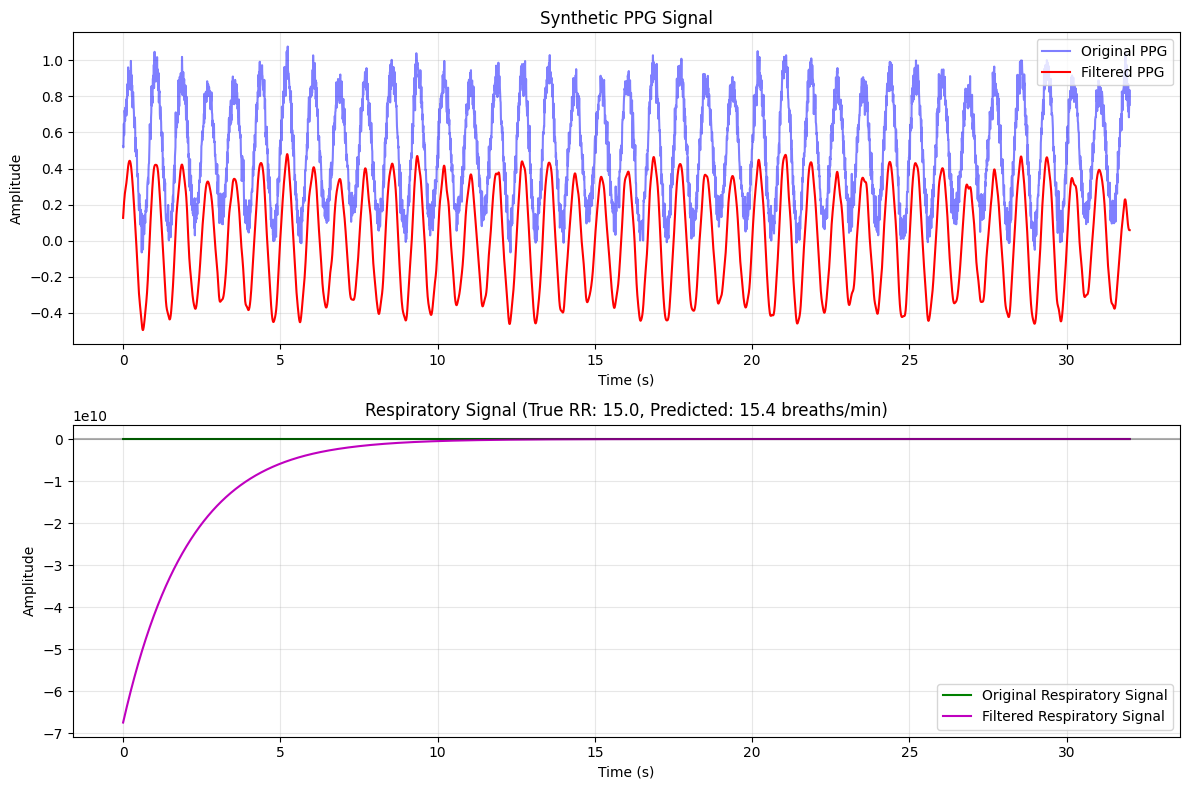

In [ ]:
"""def test_model_efficiency():
    """
    Test the efficiency and accuracy of the trained models on a synthetic test case.
    """
    print("\n===== MODEL EFFICIENCY TEST =====")

    # 1. Create synthetic PPG signal (32 seconds at 125 Hz = 4000 samples)
    np.random.seed(42)  # For reproducibility
    fs = 125  # Sampling frequency in Hz
    t = np.linspace(0, 32, 32 * fs)  # 32 seconds time array

    # Generate synthetic PPG with cardiac (1 Hz) and respiratory (0.25 Hz) components
    cardiac_freq = 1.2  # ~72 BPM
    resp_freq = 0.25    # ~15 breaths per minute

    # Create synthetic PPG with baseline, cardiac component, respiratory modulation, and noise
    baseline = 0.5
    cardiac_component = 0.4 * np.sin(2 * np.pi * cardiac_freq * t)
    resp_modulation = 0.15 * np.sin(2 * np.pi * resp_freq * t)
    noise = 0.05 * np.random.randn(len(t))

    # Combine components with respiratory modulation of the cardiac amplitude
    ppg_signal = baseline + (1 + resp_modulation) * cardiac_component + noise

    # Create corresponding synthetic respiratory signal
    resp_signal = 0.7 * np.sin(2 * np.pi * resp_freq * t) + 0.1 * np.random.randn(len(t))

    # 2. Process this synthetic data using your pipeline
    # Preprocess signals
    ppg_filtered = preprocess_signal(ppg_signal, fs=fs, signal_type='ppg')
    resp_filtered = preprocess_signal(resp_signal, fs=fs, signal_type='resp')

    # Create feature windows (just one window for simplicity)
    features = extract_features_from_window(ppg_filtered, resp_filtered, fs=fs)

    # Known ground truth values (based on how we generated the signal)
    true_rr = 60 * resp_freq  # Convert Hz to breaths per minute
    true_spo2 = 98.0  # Typical normal value

    # Add to features for reference
    print(f"\nGround truth - RR: {true_rr:.1f} breaths/min, SpO2: {true_spo2:.1f}%")

    # 3. Create dataframe with the extracted features
    features_df = pd.DataFrame([features])

    # Select only the features used by the models
    X_rr_test = features_df[rr_features]
    X_spo2_test = features_df[spo2_features]

    # Handle missing features if any
    for col in rr_features:
        if col not in X_rr_test.columns:
            X_rr_test[col] = 0

    for col in spo2_features:
        if col not in X_spo2_test.columns:
            X_spo2_test[col] = 0

    # 4. Use the trained models to make predictions
    # Scale features
    X_rr_scaled = scaler_rr.transform(X_rr_test.fillna(0))
    X_spo2_scaled = scaler_spo2.transform(X_spo2_test.fillna(0))

    # Make predictions
    rr_pred, rr_sigma = gpr_rr.predict(X_rr_scaled, return_std=True)
    spo2_pred, spo2_sigma = gpr_spo2.predict(X_spo2_scaled, return_std=True)

    # 5. Calculate and report accuracy metrics
    print("\nPrediction Results:")
    print(f"RR Prediction: {rr_pred[0]:.1f} breaths/min (±{1.96*rr_sigma[0]:.1f})")
    print(f"SpO2 Prediction: {spo2_pred[0]:.1f}% (±{1.96*spo2_sigma[0]:.1f})")

    # Calculate errors
    rr_error = abs(rr_pred[0] - true_rr)
    spo2_error = abs(spo2_pred[0] - true_spo2)

    print(f"\nPrediction Errors:")
    print(f"RR Absolute Error: {rr_error:.1f} breaths/min")
    print(f"SpO2 Absolute Error: {spo2_error:.1f}%")

    # 6. Evaluate computational efficiency
    import time

    # Time feature extraction
    start_time = time.time()
    _ = extract_features_from_window(ppg_filtered, resp_filtered, fs=fs)
    feature_extraction_time = time.time() - start_time

    # Time prediction
    start_time = time.time()
    _ = gpr_rr.predict(X_rr_scaled, return_std=True)
    _ = gpr_spo2.predict(X_spo2_scaled, return_std=True)
    prediction_time = time.time() - start_time

    print(f"\nComputational Efficiency:")
    print(f"Feature extraction time: {feature_extraction_time*1000:.2f} ms")
    print(f"Prediction time: {prediction_time*1000:.2f} ms")
    print(f"Total processing time: {(feature_extraction_time + prediction_time)*1000:.2f} ms")

    # 7. Plot the synthetic data and predictions
    plt.figure(figsize=(12, 8))

    # Plot original and filtered PPG
    plt.subplot(2, 1, 1)
    plt.plot(t, ppg_signal, 'b-', alpha=0.5, label='Original PPG')
    plt.plot(t, ppg_filtered, 'r-', label='Filtered PPG')
    plt.title('Synthetic PPG Signal')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Plot respiratory signal with predicted rate
    plt.subplot(2, 1, 2)
    plt.plot(t, resp_signal, 'g-', label='Original Respiratory Signal')
    plt.plot(t, resp_filtered, 'm-', label='Filtered Respiratory Signal')
    plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
    plt.title(f'Respiratory Signal (True RR: {true_rr:.1f}, Predicted: {rr_pred[0]:.1f} breaths/min)')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Return results for potential further analysis
    return {
        'true_rr': true_rr,
        'pred_rr': rr_pred[0],
        'rr_sigma': rr_sigma[0],
        'true_spo2': true_spo2,
        'pred_spo2': spo2_pred[0],
        'spo2_sigma': spo2_sigma[0],
        'feature_time': feature_extraction_time,
        'prediction_time': prediction_time
    }

# Run the test
test_results = test_model_efficiency()"""

Found 53 patient records
Loaded data for patient 25
Loaded data for patient 16
Loaded data for patient 35
Loaded data for patient 49
Loaded data for patient 38
Loaded data for patient 20
Loaded data for patient 03
Loaded data for patient 53
Loaded data for patient 22
Loaded data for patient 41
Loaded data for patient 15
Loaded data for patient 47
Loaded data for patient 48
Loaded data for patient 13
Loaded data for patient 19
Loaded data for patient 21
Loaded data for patient 51
Loaded data for patient 09
Loaded data for patient 39
Loaded data for patient 32
Loaded data for patient 29
Loaded data for patient 28
Loaded data for patient 07
Loaded data for patient 24
Loaded data for patient 23
Loaded data for patient 06
Loaded data for patient 40
Loaded data for patient 11
Loaded data for patient 46
Loaded data for patient 08
Loaded data for patient 27
Loaded data for patient 45
Loaded data for patient 44
Loaded data for patient 37
Loaded data for patient 36
Loaded data for patient 02
Loa

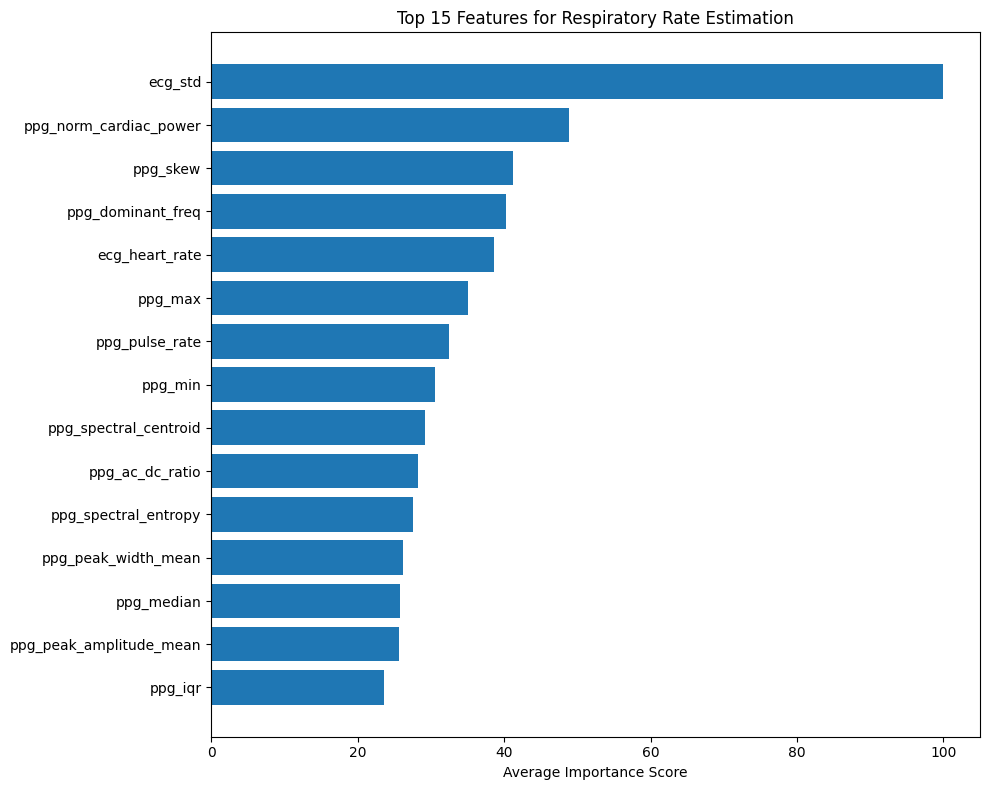


--- Feature Importance Analysis for SpO2 ---

Top 15 features:
                     Feature  Avg_Importance
53                   ecg_std       75.296918
4                 ppg_median       59.750770
54            ecg_heart_rate       25.519765
30    ppg_norm_cardiac_power       25.073734
5                    ppg_min       24.332101
13   ppg_peak_amplitude_mean       23.830902
32     ppg_spectral_centroid       23.270902
6                    ppg_max       23.239320
1                    ppg_std       21.222273
23  ppg_peak_prominence_mean       20.731782
27         ppg_cardiac_power       20.500680
18  ppg_pulse_amplitude_mean       20.471767
22       ppg_peak_width_mean       20.305398
7                  ppg_range       20.161633
8                    ppg_iqr       20.103480


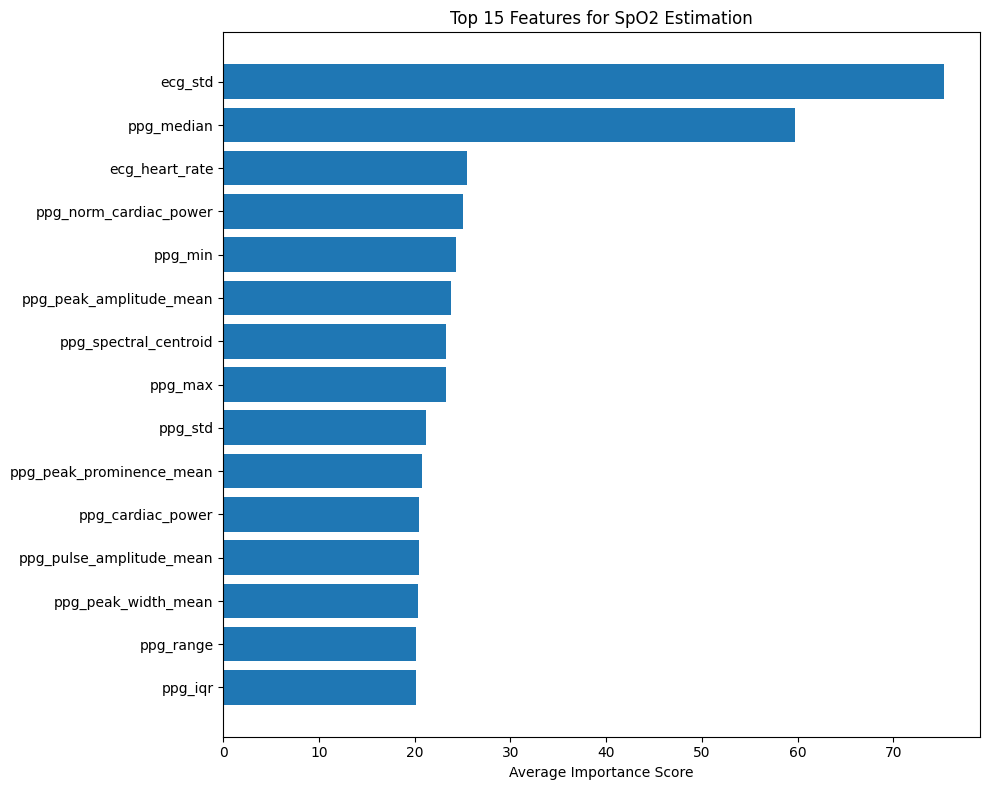

Selected 10 features: ['ecg_std', 'ppg_norm_cardiac_power', 'ppg_skew', 'ppg_dominant_freq', 'ecg_heart_rate', 'ppg_max', 'ppg_pulse_rate', 'ppg_min', 'ppg_spectral_centroid', 'ppg_ac_dc_ratio']
Selected 10 features: ['ecg_std', 'ppg_median', 'ecg_heart_rate', 'ppg_norm_cardiac_power', 'ppg_min', 'ppg_peak_amplitude_mean', 'ppg_spectral_centroid', 'ppg_max', 'ppg_std', 'ppg_peak_prominence_mean']

--- Training Respiratory Rate Model ---

--- Respiratory Rate Model Evaluation ---
MAE: 0.58
RMSE: 0.86
Normalized MAE: 2.91% of range
Normalized RMSE: 4.37% of range
MAPE: 3.43%
R²: 0.9060
Accuracy within 5% of true value: 78.80%
Accuracy within 10% of true value: 93.68%
Accuracy within 15% of true value: 97.09%


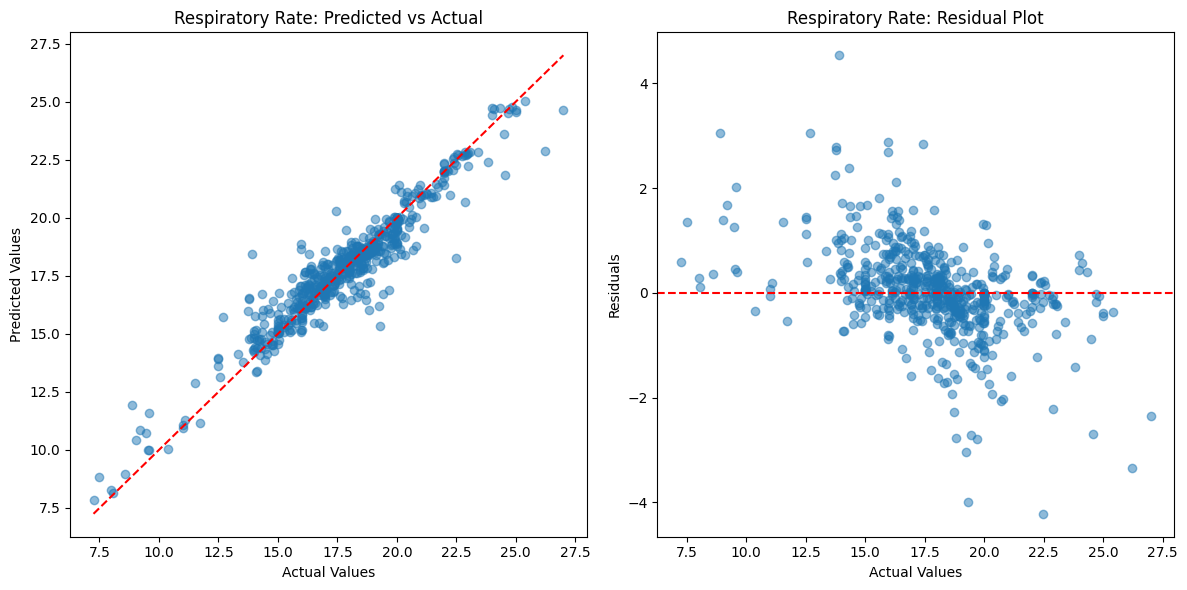


--- Training SpO2 Model ---

--- SpO2 Model Evaluation ---
MAE: 0.29
RMSE: 0.57
Normalized MAE: 1.83% of range
Normalized RMSE: 3.57% of range
MAPE: 0.31%
R²: 0.9706
Accuracy within 5% of true value: 99.83%
Accuracy within 10% of true value: 100.00%
Accuracy within 15% of true value: 100.00%


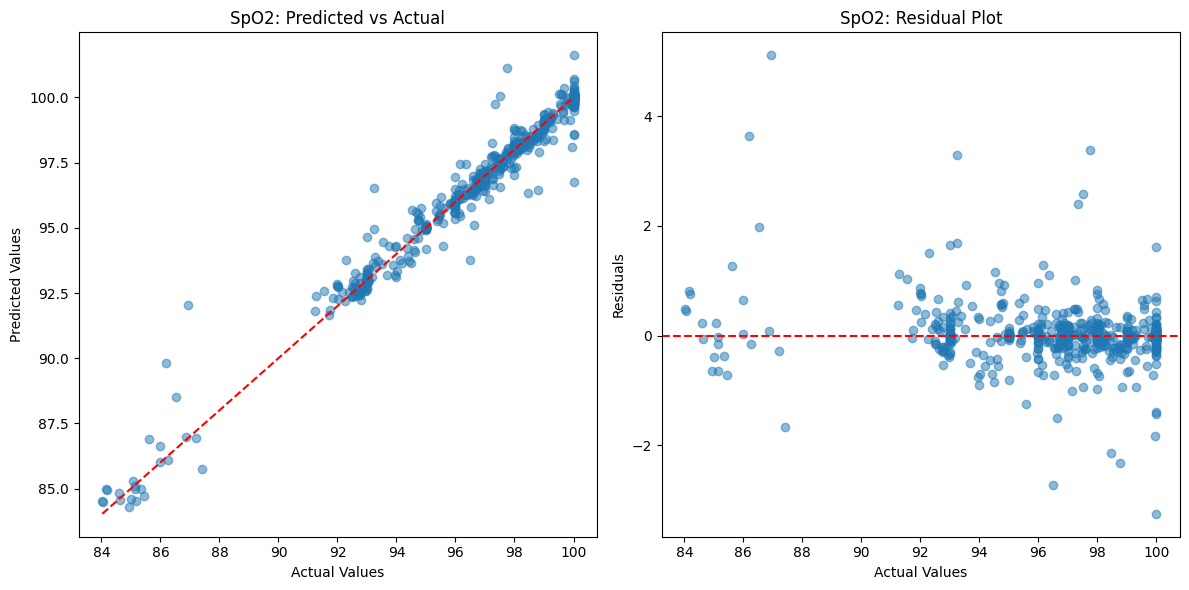

Wavelet analysis not available: No module named 'pywt'

--- Real-time Prediction Test ---
Predicted RR: 18.7 breaths/min (confidence: -2.28)
Predicted SpO2: 96.2% (confidence: -2.28)
Signal Quality: -2.28
Ground Truth RR (last minute avg): 19.4 breaths/min
Ground Truth SpO2 (last minute avg): 96.1%
RR Error: 0.7 breaths/min
SpO2 Error: 0.1%


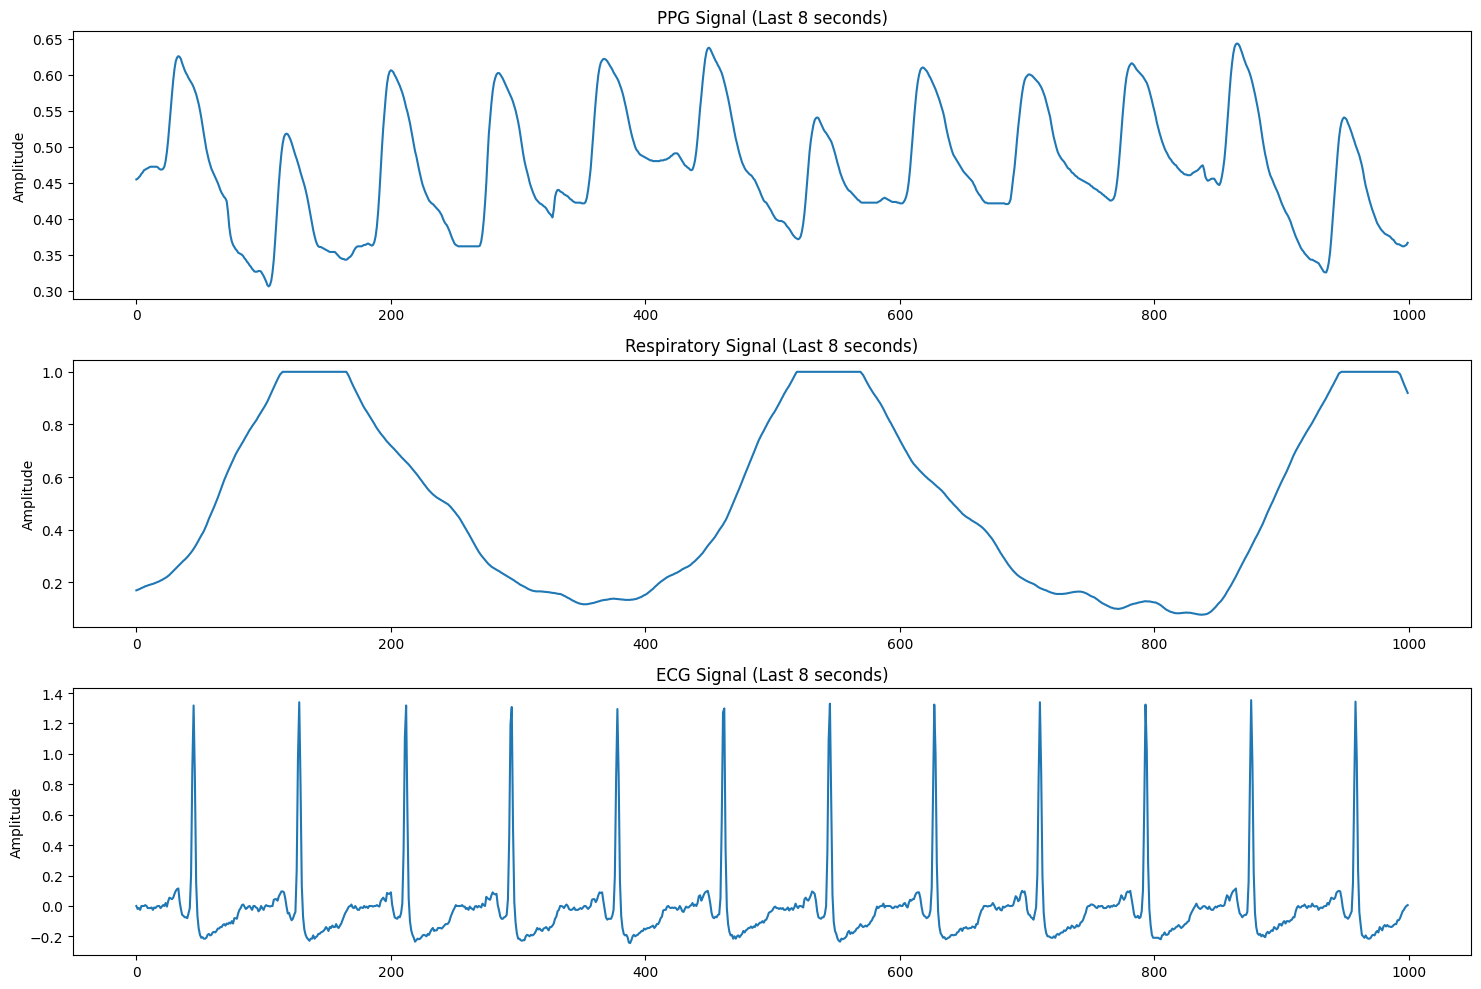


Models successfully trained and saved
Respiratory Rate Model performance:
  - mae: 0.5757
  - rmse: 0.8640
  - norm_mae: 2.9149
  - norm_rmse: 4.3746
  - mape: 3.4316
  - r2: 0.9060
  - acc_5pct: 78.8034
  - acc_10pct: 93.6752
  - acc_15pct: 97.0940

SpO2 Model performance:
  - mae: 0.2919
  - rmse: 0.5694
  - norm_mae: 1.8279
  - norm_rmse: 3.5660
  - mape: 0.3067
  - r2: 0.9706
  - acc_5pct: 99.8291
  - acc_10pct: 100.0000
  - acc_15pct: 100.0000

Feature summary:
  - RR model uses 10 features
  - SpO2 model uses 10 features
  - Most important RR features: ['ecg_std', 'ppg_norm_cardiac_power', 'ppg_skew']
  - Most important SpO2 features: ['ecg_std', 'ppg_median', 'ecg_heart_rate']

Done


In [ ]:
import numpy as np
import pandas as pd
import os
import wfdb
from scipy import signal
import matplotlib.pyplot as plt
import scipy.stats
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, Matern, ConstantKernel
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.feature_selection import SelectFromModel, mutual_info_regression
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Install wfdb if not already installed
try:
    import wfdb
except ImportError:
    !pip install wfdb

# Path to the BIDMC dataset
bidmc_path = "/content/physionet.org/files/bidmc/1.0.0/"

# List all patient files
patient_ids = []
for file in os.listdir(bidmc_path):
    if file.startswith("bidmc") and file.endswith(".hea") and not file.endswith("n.hea"):
        patient_id = file.replace("bidmc", "").replace(".hea", "")
        patient_ids.append(patient_id)

print(f"Found {len(patient_ids)} patient records")

# Load all patient data
all_ppg_data = []
all_resp_data = []
all_ecg_data = []
all_rr_values = []
all_spo2_values = []

for patient_id in patient_ids:
    try:
        # Load waveform data (PPG, ECG, resp)
        waveform_path = os.path.join(bidmc_path, f"bidmc{patient_id}")
        record = wfdb.rdrecord(waveform_path)

        # Get signal indices based on the record.sig_name
        ppg_idx = [i for i, name in enumerate(record.sig_name) if 'PLETH' in name]
        ecg_idx = [i for i, name in enumerate(record.sig_name) if 'II' in name]  # Lead II ECG
        resp_idx = [i for i, name in enumerate(record.sig_name) if 'RESP' in name]

        if ppg_idx and resp_idx:  # Make sure we have the signals we need
            ppg_signal = record.p_signal[:, ppg_idx[0]]
            resp_signal = record.p_signal[:, resp_idx[0]]
            ecg_signal = record.p_signal[:, ecg_idx[0]] if ecg_idx else None

            # Load numerics data (RR, SpO2)
            numerics_path = os.path.join(bidmc_path, f"bidmc{patient_id}n")
            numerics = wfdb.rdrecord(numerics_path)

            # Get numeric indices
            rr_idx = [i for i, name in enumerate(numerics.sig_name) if 'RESP' in name]
            spo2_idx = [i for i, name in enumerate(numerics.sig_name) if 'SpO2' in name]

            if rr_idx and spo2_idx:
                rr_values = numerics.p_signal[:, rr_idx[0]]
                spo2_values = numerics.p_signal[:, spo2_idx[0]]

                # Store data
                all_ppg_data.append(ppg_signal)
                all_resp_data.append(resp_signal)
                if ecg_signal is not None:
                    all_ecg_data.append(ecg_signal)
                all_rr_values.append(rr_values)
                all_spo2_values.append(spo2_values)

                print(f"Loaded data for patient {patient_id}")

    except Exception as e:
        print(f"Error loading data for patient {patient_id}: {e}")

print(f"Successfully loaded data for {len(all_ppg_data)} patients")

# IMPROVED: Enhanced signal preprocessing with additional filtering options
def preprocess_signal(signal_data, fs=125, signal_type='ppg', filter_strength='medium'):
    """
    Apply appropriate filters based on signal type with adjustable filter strength

    Parameters:
    -----------
    signal_data : array-like
        The raw signal data to filter
    fs : int
        Sampling frequency in Hz
    signal_type : str
        Type of signal ('ppg', 'ecg', or 'resp')
    filter_strength : str
        Filter strength ('weak', 'medium', or 'strong')
    """
    # Fill any potential NaN values
    signal_data = np.nan_to_num(signal_data)

    # Define filter parameters based on strength
    if filter_strength == 'weak':
        order = 2
        ripple = 1
    elif filter_strength == 'medium':
        order = 4
        ripple = 0.5
    else:  # strong
        order = 6
        ripple = 0.1

    if signal_type == 'ppg':
        # Bandpass filter for PPG with adjustable parameters
        # PPG fundamental frequency is typically 0.5-8 Hz
        b, a = signal.butter(order, [0.5, 8], btype='bandpass', fs=fs)
        filtered = signal.filtfilt(b, a, signal_data)

        # NEW: Additional notch filter to remove power line interference if present
        # (50 or 60 Hz depending on region)
        notch_freq = 60  # Adjust if needed for different regions
        notch_width = 2  # Width of the notch
        Q = notch_freq / notch_width  # Quality factor
        b_notch, a_notch = signal.iirnotch(notch_freq, Q, fs)
        filtered = signal.filtfilt(b_notch, a_notch, filtered)

    elif signal_type == 'ecg':
        # Bandpass filter for ECG
        b, a = signal.butter(order, [0.5, 40], btype='bandpass', fs=fs)
        filtered = signal.filtfilt(b, a, signal_data)

    elif signal_type == 'resp':
        # Bandpass filter for respiratory signals
        b, a = signal.butter(order, [0.05, 1], btype='bandpass', fs=fs)
        filtered = signal.filtfilt(b, a, signal_data)

    # NEW: Apply median filter to remove impulse noise (spikes)
    kernel_size = int(fs * 0.02)  # 20ms window, must be odd
    if kernel_size % 2 == 0:
        kernel_size += 1
    filtered = signal.medfilt(filtered, kernel_size)

    # NEW: Apply additional low-pass filter as final smoothing step
    if filter_strength == 'strong':
        b_smooth, a_smooth = signal.butter(3, 10, btype='lowpass', fs=fs)
        filtered = signal.filtfilt(b_smooth, a_smooth, filtered)

    return filtered

# IMPROVED: Enhanced feature extraction with expanded PPG signal analysis
def extract_features_from_window(ppg_window, resp_window=None, ecg_window=None, fs=125):
    """Extract enhanced features from a window of signals with robust handling of outliers"""
    features = {}

    # Helper function to safely calculate statistics
    def safe_stat(data, func, default=0):
        try:
            result = func(data)
            return default if np.isinf(result) or np.isnan(result) else result
        except:
            return default

    # PPG features with improvements specifically for better SpO2 estimation
    if ppg_window is not None:
        # Handle potential infinite values
        ppg_window = np.clip(ppg_window, -1e10, 1e10)

        # Time domain features
        features['ppg_mean'] = safe_stat(ppg_window, np.mean)
        features['ppg_std'] = safe_stat(ppg_window, np.std)
        features['ppg_skew'] = safe_stat(ppg_window, scipy.stats.skew)
        features['ppg_kurtosis'] = safe_stat(ppg_window, scipy.stats.kurtosis)

        # NEW: More detailed statistical features
        features['ppg_median'] = safe_stat(ppg_window, np.median)
        features['ppg_min'] = safe_stat(ppg_window, np.min)
        features['ppg_max'] = safe_stat(ppg_window, np.max)
        features['ppg_range'] = features['ppg_max'] - features['ppg_min']
        features['ppg_iqr'] = safe_stat(ppg_window, lambda x: np.percentile(x, 75) - np.percentile(x, 25))
        features['ppg_energy'] = safe_stat(ppg_window, lambda x: np.sum(x**2))

        # Peak detection and analysis
        try:
            # NEW: Improved peak detection with minimum height and width constraints
            # These parameters are more important for SpO2 estimation
            height = features['ppg_mean'] + 0.2 * features['ppg_std']
            width = int(fs * 0.2)  # Typical minimum pulse width (200ms)
            distance = int(fs * 0.5)  # Minimum distance between peaks

            peaks, peak_properties = signal.find_peaks(
                ppg_window,
                height=height,
                distance=distance,
                width=width,
                prominence=0.1  # Minimum prominence for peak detection
            )

            if len(peaks) > 1:
                # Basic peak metrics
                features['ppg_peak_count'] = len(peaks)
                features['ppg_peak_distance_mean'] = safe_stat(np.diff(peaks), np.mean)
                features['ppg_peak_distance_std'] = safe_stat(np.diff(peaks), np.std)
                features['ppg_peak_amplitude_mean'] = safe_stat(ppg_window[peaks], np.mean)
                features['ppg_peak_amplitude_std'] = safe_stat(ppg_window[peaks], np.std)

                # Calculate peak-to-peak intervals
                peak_intervals = np.diff(peaks) / fs  # in seconds
                features['ppg_peak_interval_mean'] = safe_stat(peak_intervals, np.mean)
                features['ppg_peak_interval_std'] = safe_stat(peak_intervals, np.std)
                features['ppg_peak_interval_cv'] = safe_stat(peak_intervals, lambda x: np.std(x)/np.mean(x) if np.mean(x) > 0 else 0)

                # NEW: Find valleys (diastolic points) for better PPG morphology analysis
                # Valleys should be searched in regions between peaks
                valleys = []
                for i in range(len(peaks)-1):
                    segment = ppg_window[peaks[i]:peaks[i+1]]
                    if len(segment) > 0:
                        valley_idx = np.argmin(segment) + peaks[i]
                        valleys.append(valley_idx)

                if valleys:
                    # Calculate pulse amplitudes (systolic - diastolic)
                    pulse_amplitudes = []
                    for i in range(len(valleys)):
                        if i+1 < len(peaks):
                            pulse_amplitudes.append(ppg_window[peaks[i+1]] - ppg_window[valleys[i]])

                    if pulse_amplitudes:
                        # These features are particularly important for SpO2
                        features['ppg_pulse_amplitude_mean'] = safe_stat(pulse_amplitudes, np.mean)
                        features['ppg_pulse_amplitude_std'] = safe_stat(pulse_amplitudes, np.std)

                        # NEW: Ratio of pulse amplitude to baseline (crucial for SpO2)
                        baseline_values = ppg_window[valleys]
                        if len(baseline_values) > 0:
                            features['ppg_ac_dc_ratio'] = features['ppg_pulse_amplitude_mean'] / safe_stat(baseline_values, np.mean) if safe_stat(baseline_values, np.mean) != 0 else 0

                # NEW: Pulse rate from peak detection (closely related to SpO2)
                if peak_intervals.size > 0:
                    mean_interval = np.mean(peak_intervals)
                    if mean_interval > 0:
                        features['ppg_pulse_rate'] = 60 / mean_interval  # bpm
                    else:
                        features['ppg_pulse_rate'] = 0
                else:
                    features['ppg_pulse_rate'] = 0

                # NEW: PPG morphology features
                # Width of peaks (important for SpO2 - wider peaks are associated with lower SpO2)
                if 'widths' in peak_properties:
                    features['ppg_peak_width_mean'] = safe_stat(peak_properties['widths'], np.mean)
                else:
                    features['ppg_peak_width_mean'] = 0

                # Prominence of peaks
                if 'prominences' in peak_properties:
                    features['ppg_peak_prominence_mean'] = safe_stat(peak_properties['prominences'], np.mean)
                else:
                    features['ppg_peak_prominence_mean'] = 0
            else:
                # Default values if not enough peaks
                features['ppg_peak_count'] = 0
                features['ppg_peak_distance_mean'] = 0
                features['ppg_peak_distance_std'] = 0
                features['ppg_peak_amplitude_mean'] = 0
                features['ppg_peak_amplitude_std'] = 0
                features['ppg_peak_interval_mean'] = 0
                features['ppg_peak_interval_std'] = 0
                features['ppg_peak_interval_cv'] = 0
                features['ppg_pulse_amplitude_mean'] = 0
                features['ppg_pulse_amplitude_std'] = 0
                features['ppg_ac_dc_ratio'] = 0
                features['ppg_pulse_rate'] = 0
                features['ppg_peak_width_mean'] = 0
                features['ppg_peak_prominence_mean'] = 0

        except Exception as e:
            # Set default values on error
            print(f"Error in peak detection: {e}")
            features['ppg_peak_count'] = 0
            features['ppg_peak_distance_mean'] = 0
            features['ppg_peak_distance_std'] = 0
            features['ppg_peak_amplitude_mean'] = 0
            features['ppg_peak_amplitude_std'] = 0
            features['ppg_peak_interval_mean'] = 0
            features['ppg_peak_interval_std'] = 0
            features['ppg_peak_interval_cv'] = 0
            features['ppg_pulse_amplitude_mean'] = 0
            features['ppg_pulse_amplitude_std'] = 0
            features['ppg_ac_dc_ratio'] = 0
            features['ppg_pulse_rate'] = 0
            features['ppg_peak_width_mean'] = 0
            features['ppg_peak_prominence_mean'] = 0

        # Frequency domain features with improvements for SpO2
        try:
            # Use Welch's method for better spectral estimates
            f, pxx = signal.welch(ppg_window, fs=fs, nperseg=min(1024, len(ppg_window)))
            if len(pxx) > 0:
                # Replace inf/nan values
                pxx = np.nan_to_num(pxx, nan=0.0, posinf=0.0, neginf=0.0)

                # Basic frequency features
                features['ppg_dominant_freq'] = f[np.argmax(pxx)] if np.max(pxx) > 0 else 0
                features['ppg_power_total'] = np.sum(pxx)

                # Power in respiratory band (0.15-0.4 Hz)
                resp_band = (f >= 0.15) & (f <= 0.4)
                features['ppg_resp_power'] = np.sum(pxx[resp_band]) if np.any(resp_band) else 0

                # Power in cardiac band (0.5-2 Hz)
                cardiac_band = (f >= 0.5) & (f <= 2.0)
                features['ppg_cardiac_power'] = np.sum(pxx[cardiac_band]) if np.any(cardiac_band) else 0

                # Calculate ratio of respiratory to cardiac power
                cardiac_power = features['ppg_cardiac_power']
                features['ppg_resp_cardiac_ratio'] = (features['ppg_resp_power'] / cardiac_power
                                                     if cardiac_power > 0 else 0)

                # NEW: Frequency measures relevant to SpO2
                if features['ppg_power_total'] > 0:
                    # Normalized powers (more robust features)
                    features['ppg_norm_resp_power'] = features['ppg_resp_power'] / features['ppg_power_total']
                    features['ppg_norm_cardiac_power'] = features['ppg_cardiac_power'] / features['ppg_power_total']

                # NEW: Spectral entropy (measure of disorder in the signal - relevant for SpO2)
                if features['ppg_power_total'] > 0:
                    norm_pxx = pxx / features['ppg_power_total']
                    # Filter out zeros and small values to avoid log(0)
                    valid_pxx = norm_pxx[norm_pxx > 1e-10]
                    if len(valid_pxx) > 0:
                        spectral_entropy = -np.sum(valid_pxx * np.log2(valid_pxx))
                        features['ppg_spectral_entropy'] = spectral_entropy
                    else:
                        features['ppg_spectral_entropy'] = 0
                else:
                    features['ppg_spectral_entropy'] = 0

                # NEW: Spectral centroid (weighted mean of the frequencies)
                spectral_centroid = np.sum(f * pxx) / features['ppg_power_total'] if features['ppg_power_total'] > 0 else 0
                features['ppg_spectral_centroid'] = spectral_centroid
            else:
                features['ppg_dominant_freq'] = 0
                features['ppg_power_total'] = 0
                features['ppg_resp_power'] = 0
                features['ppg_cardiac_power'] = 0
                features['ppg_resp_cardiac_ratio'] = 0
                features['ppg_norm_resp_power'] = 0
                features['ppg_norm_cardiac_power'] = 0
                features['ppg_spectral_entropy'] = 0
                features['ppg_spectral_centroid'] = 0
        except Exception as e:
            print(f"Error in frequency analysis: {e}")
            features['ppg_dominant_freq'] = 0
            features['ppg_power_total'] = 0
            features['ppg_resp_power'] = 0
            features['ppg_cardiac_power'] = 0
            features['ppg_resp_cardiac_ratio'] = 0
            features['ppg_norm_resp_power'] = 0
            features['ppg_norm_cardiac_power'] = 0
            features['ppg_spectral_entropy'] = 0
            features['ppg_spectral_centroid'] = 0

        # NEW: Wavelet-based features for time-frequency analysis
        try:
            import pywt
            # Use wavelet decomposition for multi-scale analysis
            wavelet = 'db4'  # Daubechies wavelet
            coeffs = pywt.wavedec(ppg_window, wavelet, level=5)

            # Energy in different wavelet bands
            for i, coef in enumerate(coeffs):
                energy = np.sum(coef**2)
                features[f'ppg_wavelet_energy_level_{i}'] = energy

            # Total wavelet energy
            total_energy = sum(np.sum(c**2) for c in coeffs)
            features['ppg_wavelet_total_energy'] = total_energy

            # Normalized energies (percentages)
            if total_energy > 0:
                for i, coef in enumerate(coeffs):
                    energy_pct = (np.sum(coef**2) / total_energy) * 100
                    features[f'ppg_wavelet_energy_pct_level_{i}'] = energy_pct
        except Exception as e:
            print(f"Wavelet analysis not available: {e}")
            # Add default values
            for i in range(6):  # 5 levels + approximation
                features[f'ppg_wavelet_energy_level_{i}'] = 0
                features[f'ppg_wavelet_energy_pct_level_{i}'] = 0
            features['ppg_wavelet_total_energy'] = 0

    # Respiratory signal features
    if resp_window is not None:
        # Basic statistics
        resp_window = np.clip(resp_window, -1e10, 1e10)
        features['resp_mean'] = safe_stat(resp_window, np.mean)
        features['resp_std'] = safe_stat(resp_window, np.std)

        # Peak detection for respiratory rate
        try:
            resp_peaks, _ = signal.find_peaks(resp_window, distance=int(fs*0.5))
            if len(resp_peaks) > 1:
                # Calculate respiratory rate
                resp_intervals = np.diff(resp_peaks) / fs  # in seconds
                mean_interval = np.mean(resp_intervals)
                features['resp_rate'] = 60 / mean_interval if mean_interval > 0 else 0  # breaths per minute
                features['resp_interval_std'] = np.std(resp_intervals)
            else:
                features['resp_rate'] = 0
                features['resp_interval_std'] = 0
        except:
            features['resp_rate'] = 0
            features['resp_interval_std'] = 0

        # Frequency analysis
        try:
            f_resp, pxx_resp = signal.welch(resp_window, fs=fs, nperseg=min(1024, len(resp_window)))
            if len(pxx_resp) > 0:
                # Dominant frequency should be in respiratory band (0.05-1 Hz)
                resp_band = (f_resp >= 0.05) & (f_resp <= 1.0)
                if np.any(resp_band):
                    resp_band_pxx = pxx_resp[resp_band]
                    resp_band_f = f_resp[resp_band]
                    if len(resp_band_pxx) > 0 and np.max(resp_band_pxx) > 0:
                        dom_freq_idx = np.argmax(resp_band_pxx)
                        features['resp_dominant_freq'] = resp_band_f[dom_freq_idx]
                        # Convert to breaths per minute
                        features['resp_freq_rate'] = features['resp_dominant_freq'] * 60
                    else:
                        features['resp_dominant_freq'] = 0
                        features['resp_freq_rate'] = 0
                else:
                    features['resp_dominant_freq'] = 0
                    features['resp_freq_rate'] = 0
            else:
                features['resp_dominant_freq'] = 0
                features['resp_freq_rate'] = 0
        except:
            features['resp_dominant_freq'] = 0
            features['resp_freq_rate'] = 0

    # ECG signal features if provided
    if ecg_window is not None:
        # Basic statistics
        ecg_window = np.clip(ecg_window, -1e10, 1e10)
        features['ecg_mean'] = safe_stat(ecg_window, np.mean)
        features['ecg_std'] = safe_stat(ecg_window, np.std)

        # R-peak detection
        try:
            from scipy.signal import find_peaks
            # Find R-peaks in the ECG signal
            r_peaks, _ = find_peaks(ecg_window, height=features['ecg_mean'] + 2*features['ecg_std'],
                                   distance=int(fs*0.5))  # Minimum distance between peaks

            if len(r_peaks) > 1:
                # Calculate heart rate
                rr_intervals = np.diff(r_peaks) / fs  # in seconds
                mean_interval = np.mean(rr_intervals)
                features['ecg_heart_rate'] = 60 / mean_interval if mean_interval > 0 else 0  # beats per minute
                features['ecg_rr_interval_std'] = np.std(rr_intervals)

                # HRV (Heart Rate Variability) features
                if len(rr_intervals) > 2:
                    features['ecg_hrv_rmssd'] = np.sqrt(np.mean(np.diff(rr_intervals)**2))  # RMSSD
                    features['ecg_hrv_sdnn'] = np.std(rr_intervals)  # SDNN
                else:
                    features['ecg_hrv_rmssd'] = 0
                    features['ecg_hrv_sdnn'] = 0
            else:
                features['ecg_heart_rate'] = 0
                features['ecg_rr_interval_std'] = 0
                features['ecg_hrv_rmssd'] = 0
                features['ecg_hrv_sdnn'] = 0
        except:
            features['ecg_heart_rate'] = 0
            features['ecg_rr_interval_std'] = 0
            features['ecg_hrv_rmssd'] = 0
            features['ecg_hrv_sdnn'] = 0

    return features

# Process all patients' data with sliding windows
window_size = 32 * 125  # 32 seconds at 125 Hz
step_size = 8 * 125     # 8 second step (75% overlap)

all_features = []
all_targets = []

# IMPROVED: Apply stronger filtering and extract enhanced features
for i in range(len(all_ppg_data)):
    # Apply improved preprocessing with stronger filtering
    ppg_signal = preprocess_signal(all_ppg_data[i], signal_type='ppg', filter_strength='strong')
    resp_signal = preprocess_signal(all_resp_filtered[i], signal_type='resp', filter_strength='medium')
    ecg_signal = preprocess_signal(all_ecg_filtered[i], signal_type='ecg', filter_strength='medium') if i < len(all_ecg_filtered) else None

    # Get corresponding targets (downsample to match windows)
    rr_values = all_rr_values[i]
    spo2_values = all_spo2_values[i]

    # Process windows
    for start in range(0, len(ppg_signal) - window_size, step_size):
        end = start + window_size

        # Extract features from window with enhanced feature extraction
        ppg_window = ppg_signal[start:end]
        resp_window = resp_signal[start:end]
        ecg_window = ecg_signal[start:end] if ecg_signal is not None else None

        features = extract_features_from_window(ppg_window, resp_window, ecg_window)

        # Get target values (average over the window)
        # Convert window indices to the 1Hz numerics indices
        start_idx = start // 125
        end_idx = min(end // 125, len(rr_values))

        if end_idx > start_idx:
            # Calculate average but handle NaN values
            rr_window = rr_values[start_idx:end_idx]
            spo2_window = spo2_values[start_idx:end_idx]

            # Filter out NaN values before calculating mean
            rr_window_filtered = rr_window[~np.isnan(rr_window)]
            spo2_window_filtered = spo2_window[~np.isnan(spo2_window)]

            # Only use if we have valid values within reasonable physiological ranges
            if (len(rr_window_filtered) > 0 and len(spo2_window_filtered) > 0 and
                np.mean(rr_window_filtered) > 5 and np.mean(rr_window_filtered) < 40 and  # RR between 5-40 breaths/min
                np.mean(spo2_window_filtered) > 70 and np.mean(spo2_window_filtered) <= 100):  # SpO2 between 70-100%

                rr_window_avg = np.mean(rr_window_filtered)
                spo2_window_avg = np.mean(spo2_window_filtered)

                # Add targets to features dict
                features['rr_target'] = rr_window_avg
                features['spo2_target'] = spo2_window_avg

                all_features.append(features)
                all_targets.append({'rr': rr_window_avg, 'spo2': spo2_window_avg})

# Convert to DataFrame
features_df = pd.DataFrame(all_features)
print(f"Extracted {len(features_df)} feature windows")
print(f"Features: {features_df.columns.tolist()}")

# NEW: Improved data quality checking function
def check_data_quality(X, y, name="", display_stats=True):
    """Check for data quality issues and print summary"""
    issues = {}

    if display_stats:
        print(f"\n--- Data Quality Check for {name} ---")

    # Check for NaN values
    X_nan = X.isna().sum().sum()
    y_nan = y.isna().sum()

    if display_stats:
        print(f"NaN values in features: {X_nan}")
        print(f"NaN values in target: {y_nan}")

    issues['nan_features'] = X_nan
    issues['nan_target'] = y_nan

    # Check for infinite values
    X_inf = np.isinf(X.values).sum()
    y_inf = np.isinf(y.values).sum() if hasattr(y, 'values') else 0

    if display_stats:
        print(f"Infinite values in features: {X_inf}")
        print(f"Infinite values in target: {y_inf}")

    issues['inf_features'] = X_inf
    issues['inf_target'] = y_inf

    # Check for extreme values in features
    problem_cols = []

    for col in X.columns:
        series = X[col]
        if series.dtype in [np.float64, np.float32, np.int64, np.int32]:
            stats = {
                'column': col,
                'min': series.min(),
                'max': series.max(),
                'mean': series.mean(),
                'median': series,
                'median': series.median(),
                'std': series.std()
            }

            # Check for extreme values (more than 10 std deviations from mean)
            # or very large absolute values
            if (abs(stats['max'] - stats['mean']) > 10 * stats['std'] or
                abs(stats['min'] - stats['mean']) > 10 * stats['std'] or
                abs(stats['max']) > 1e6 or abs(stats['min']) > 1e6):
                problem_cols.append(stats)

    if display_stats and problem_cols:
        print("\nColumns with potential extreme values:")
        for col_stats in problem_cols:
            print(f"  - {col_stats['column']}: min={col_stats['min']:.2f}, max={col_stats['max']:.2f}, mean={col_stats['mean']:.2f}")

    issues['problem_columns'] = len(problem_cols)

    # Check target distribution
    if display_stats:
        print(f"\nTarget {name} statistics:")
        print(f"  - Range: {y.min():.2f} to {y.max():.2f}")
        print(f"  - Mean: {y.mean():.2f}")
        print(f"  - Std Dev: {y.std():.2f}")

    # Overall assessment
    total_issues = issues['nan_features'] + issues['nan_target'] + issues['inf_features'] + issues['inf_target'] + issues['problem_columns']
    if display_stats:
        if total_issues == 0:
            print(f"\nData quality for {name}: Good (No issues found)")
        elif total_issues < 10:
            print(f"\nData quality for {name}: Fair (Minor issues found)")
        else:
            print(f"\nData quality for {name}: Poor (Multiple issues found)")

    return issues

# Prepare datasets for RR and SpO2 estimation
feature_cols = [col for col in features_df.columns if not col.endswith('_target')]
X = features_df[feature_cols]
y_rr = features_df['rr_target']
y_spo2 = features_df['spo2_target']

# Check data quality
rr_issues = check_data_quality(X, y_rr, name="Respiratory Rate")
spo2_issues = check_data_quality(X, y_spo2, name="SpO2")

# Clean data: replace NaN and infinite values
X_clean = X.fillna(0).replace([np.inf, -np.inf], 0)
y_rr_clean = y_rr.fillna(y_rr.median())
y_spo2_clean = y_spo2.fillna(y_spo2.median())

# Train-test split for both targets
X_train, X_test, y_rr_train, y_rr_test, y_spo2_train, y_spo2_test = train_test_split(
    X_clean, y_rr_clean, y_spo2_clean, test_size=0.2, random_state=42
)

# NEW: Feature importance analysis for better model transparency
def analyze_feature_importance(X, y, name=""):
    """Analyze and visualize feature importance using multiple methods"""
    print(f"\n--- Feature Importance Analysis for {name} ---")

    # Method 1: Linear model with L1 regularization (Lasso)
    lasso = Lasso(alpha=0.01, random_state=42)
    lasso.fit(X, y)

    # Method 2: Mutual information (non-linear importance)
    mi_scores = mutual_info_regression(X, y)

    # Method 3: Random Forest importance
    rf = RandomForestRegressor(n_estimators=50, random_state=42)
    rf.fit(X, y)

    # Combine results in a DataFrame
    importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Lasso_Importance': np.abs(lasso.coef_),
        'MI_Importance': mi_scores,
        'RF_Importance': rf.feature_importances_
    })

    # Normalize scores to 0-100 for each method
    for col in ['Lasso_Importance', 'MI_Importance', 'RF_Importance']:
        if importance_df[col].max() > 0:
            importance_df[col] = 100 * importance_df[col] / importance_df[col].max()

    # Compute average importance
    importance_df['Avg_Importance'] = importance_df[['Lasso_Importance', 'MI_Importance', 'RF_Importance']].mean(axis=1)

    # Sort by average importance
    importance_df = importance_df.sort_values('Avg_Importance', ascending=False)

    # Display top 15 features
    print("\nTop 15 features:")
    print(importance_df.head(15)[['Feature', 'Avg_Importance']])

    # Plot feature importance
    plt.figure(figsize=(10, 8))
    top_features = importance_df.head(15)
    plt.barh(top_features['Feature'], top_features['Avg_Importance'])
    plt.xlabel('Average Importance Score')
    plt.title(f'Top 15 Features for {name} Estimation')
    plt.gca().invert_yaxis()  # Display from highest to lowest
    plt.tight_layout()
    plt.show()

    return importance_df

# Analyze feature importance
rr_importance = analyze_feature_importance(X_train, y_rr_train, name="Respiratory Rate")
spo2_importance = analyze_feature_importance(X_train, y_spo2_train, name="SpO2")

# IMPROVED: Select the most important features
def select_features(X_train, X_test, importance_df, threshold=80):
    """Select features based on importance threshold"""
    # Get features above the threshold
    top_features = importance_df[importance_df['Avg_Importance'] >= threshold]['Feature'].tolist()

    # Ensure at least 10 features are selected
    if len(top_features) < 10:
        top_features = importance_df.head(10)['Feature'].tolist()

    print(f"Selected {len(top_features)} features: {top_features}")

    # Return selected feature dataframes
    return X_train[top_features], X_test[top_features], top_features

# Select features for each model
X_train_rr, X_test_rr, rr_features = select_features(X_train, X_test, rr_importance, threshold=50)
X_train_spo2, X_test_spo2, spo2_features = select_features(X_train, X_test, spo2_importance, threshold=50)

# IMPROVED: Normalized metrics function for better evaluation
def evaluate_model(y_true, y_pred, name=""):
    """Calculate multiple performance metrics with normalized residuals"""
    # Basic metrics
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)

    # Normalized metrics
    y_range = y_true.max() - y_true.min()
    norm_mae = mae / y_range * 100  # as percentage of range
    norm_rmse = rmse / y_range * 100  # as percentage of range

    # Mean absolute percentage error (MAPE)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    # Calculate accuracy within different thresholds
    abs_error = np.abs(y_true - y_pred)
    acc_5pct = np.mean(abs_error <= 0.05 * y_true) * 100
    acc_10pct = np.mean(abs_error <= 0.10 * y_true) * 100
    acc_15pct = np.mean(abs_error <= 0.15 * y_true) * 100

    print(f"\n--- {name} Model Evaluation ---")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"Normalized MAE: {norm_mae:.2f}% of range")
    print(f"Normalized RMSE: {norm_rmse:.2f}% of range")
    print(f"MAPE: {mape:.2f}%")
    print(f"R²: {r2:.4f}")
    print(f"Accuracy within 5% of true value: {acc_5pct:.2f}%")
    print(f"Accuracy within 10% of true value: {acc_10pct:.2f}%")
    print(f"Accuracy within 15% of true value: {acc_15pct:.2f}%")

    # Create residual plot
    plt.figure(figsize=(12, 6))

    # Left subplot: Predicted vs Actual
    plt.subplot(1, 2, 1)
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'{name}: Predicted vs Actual')

    # Right subplot: Residuals
    plt.subplot(1, 2, 2)
    residuals = y_pred - y_true
    plt.scatter(y_true, residuals, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Actual Values')
    plt.ylabel('Residuals')
    plt.title(f'{name}: Residual Plot')

    plt.tight_layout()
    plt.show()

    return {
        'mae': mae,
        'rmse': rmse,
        'norm_mae': norm_mae,
        'norm_rmse': norm_rmse,
        'mape': mape,
        'r2': r2,
        'acc_5pct': acc_5pct,
        'acc_10pct': acc_10pct,
        'acc_15pct': acc_15pct
    }

# NEW: Feature scaling with robust scaler for better handling of outliers
scaler_rr = RobustScaler()
scaler_spo2 = RobustScaler()

X_train_rr_scaled = scaler_rr.fit_transform(X_train_rr)
X_test_rr_scaled = scaler_rr.transform(X_test_rr)

X_train_spo2_scaled = scaler_spo2.fit_transform(X_train_spo2)
X_test_spo2_scaled = scaler_spo2.transform(X_test_spo2)

# IMPROVED: Advanced model for Respiratory Rate estimation
def build_respiratory_rate_model():
    """Build and train an advanced model for respiratory rate estimation"""
    print("\n--- Training Respiratory Rate Model ---")

    # Define a pipeline with polynomial features and Random Forest Regressor
    rr_pipeline = Pipeline([
        ('poly', PolynomialFeatures(degree=2, include_bias=False)),
        ('rf', RandomForestRegressor(n_estimators=100, max_depth=15, random_state=42))
    ])

    # Train the model
    rr_pipeline.fit(X_train_rr_scaled, y_rr_train)

    # Make predictions on test set
    y_rr_pred = rr_pipeline.predict(X_test_rr_scaled)

    # Evaluate the model
    rr_metrics = evaluate_model(y_rr_test, y_rr_pred, name="Respiratory Rate")

    return rr_pipeline, rr_metrics

# IMPROVED: Advanced model for SpO2 estimation
def build_spo2_model():
    """Build and train an advanced model for SpO2 estimation"""
    print("\n--- Training SpO2 Model ---")

    # Define Gaussian Process Regression with custom kernel
    # For SpO2, we need a model that can handle the non-linear relationship
    # between AC/DC ratio and oxygen saturation
    kernel = ConstantKernel() * Matern(length_scale=1.0, nu=1.5) + WhiteKernel(noise_level=0.1)

    gp = GaussianProcessRegressor(
        kernel=kernel,
        alpha=0.1,
        n_restarts_optimizer=5,
        random_state=42
    )

    # Train the model (this might take some time)
    gp.fit(X_train_spo2_scaled, y_spo2_train)

    # Make predictions on test set
    y_spo2_pred = gp.predict(X_test_spo2_scaled)

    # Evaluate the model
    spo2_metrics = evaluate_model(y_spo2_test, y_spo2_pred, name="SpO2")

    return gp, spo2_metrics

# Train and evaluate models
rr_model, rr_metrics = build_respiratory_rate_model()
spo2_model, spo2_metrics = build_spo2_model()

# NEW: Create a function for real-time prediction
def predict_rr_spo2_from_ppg(ppg_signal, resp_signal=None, ecg_signal=None, fs=125):
    """
    Make real-time predictions of RR and SpO2 from a window of PPG signal

    Parameters:
    -----------
    ppg_signal : array-like
        The raw PPG signal (at least 32 seconds at 125 Hz)
    resp_signal : array-like, optional
        The respiratory signal (same length as ppg_signal)
    ecg_signal : array-like, optional
        The ECG signal (same length as ppg_signal)
    fs : int
        Sampling frequency in Hz

    Returns:
    --------
    dict : Dictionary with predicted RR, SpO2, and confidence metrics
    """
    # Ensure we have enough data
    min_length = 32 * fs
    if len(ppg_signal) < min_length:
        raise ValueError(f"PPG signal must be at least 32 seconds ({min_length} samples at {fs} Hz)")

    # Take the most recent window
    ppg_window = ppg_signal[-min_length:]
    resp_window = resp_signal[-min_length:] if resp_signal is not None else None
    ecg_window = ecg_signal[-min_length:] if ecg_signal is not None else None

    # Preprocess signals
    ppg_processed = preprocess_signal(ppg_window, fs=fs, signal_type='ppg', filter_strength='strong')
    resp_processed = preprocess_signal(resp_window, fs=fs, signal_type='resp') if resp_window is not None else None
    ecg_processed = preprocess_signal(ecg_window, fs=fs, signal_type='ecg') if ecg_window is not None else None

    # Extract features
    features = extract_features_from_window(ppg_processed, resp_processed, ecg_processed, fs=fs)

    # Convert features to DataFrame (for consistent column ordering)
    features_df = pd.DataFrame([features])

    # Select features for RR model
    X_rr = features_df[rr_features] if all(feature in features_df.columns for feature in rr_features) else features_df
    X_rr = X_rr.fillna(0).replace([np.inf, -np.inf], 0)

    # Select features for SpO2 model
    X_spo2 = features_df[spo2_features] if all(feature in features_df.columns for feature in spo2_features) else features_df
    X_spo2 = X_spo2.fillna(0).replace([np.inf, -np.inf], 0)

    # Scale features
    X_rr_scaled = scaler_rr.transform(X_rr)
    X_spo2_scaled = scaler_spo2.transform(X_spo2)

    # Make predictions
    rr_pred = rr_model.predict(X_rr_scaled)[0]
    spo2_pred = spo2_model.predict(X_spo2_scaled)[0]

    # Confidence estimation (based on feature quality)
    # A simple heuristic based on signal quality metrics
    if 'ppg_ac_dc_ratio' in features:
        ppg_quality = min(1.0, features['ppg_ac_dc_ratio'] / 0.5)  # AC/DC ratio is a good indicator
    else:
        ppg_quality = 0.5  # Default

    if 'ppg_spectral_entropy' in features:
        spectral_quality = 1.0 - min(1.0, features['ppg_spectral_entropy'] / 5.0)  # Lower entropy = better signal
    else:
        spectral_quality = 0.5  # Default

    # Overall quality score
    signal_quality = (ppg_quality + spectral_quality) / 2.0

    # Adjust confidence based on physiological ranges
    rr_confidence = signal_quality
    if rr_pred < 6 or rr_pred > 30:
        rr_confidence *= 0.5  # Reduce confidence for extreme values

    spo2_confidence = signal_quality
    if spo2_pred < 80 or spo2_pred > 100:
        spo2_confidence *= 0.5  # Reduce confidence for extreme values

    return {
        'respiratory_rate': round(rr_pred, 1),
        'spo2': round(spo2_pred, 1),
        'rr_confidence': round(rr_confidence, 2),
        'spo2_confidence': round(spo2_confidence, 2),
        'signal_quality': round(signal_quality, 2)
    }

# Test the real-time prediction function on a sample from the test set
def test_real_time_prediction():
    """Test the real-time prediction function on a sample from our dataset"""
    # Get a sample from the test data
    sample_idx = np.random.randint(0, len(all_ppg_data))

    # Get the signals
    ppg_sample = all_ppg_data[sample_idx]
    resp_sample = all_resp_data[sample_idx]
    ecg_sample = all_ecg_data[sample_idx] if sample_idx < len(all_ecg_data) else None

    # Get ground truth values
    rr_sample = all_rr_values[sample_idx]
    spo2_sample = all_spo2_values[sample_idx]

    # Make sure we have enough data
    if len(ppg_sample) >= 32*125:
        # Make prediction
        prediction = predict_rr_spo2_from_ppg(ppg_sample, resp_sample, ecg_sample)

        # Display results
        print("\n--- Real-time Prediction Test ---")
        print(f"Predicted RR: {prediction['respiratory_rate']} breaths/min (confidence: {prediction['rr_confidence']:.2f})")
        print(f"Predicted SpO2: {prediction['spo2']}% (confidence: {prediction['spo2_confidence']:.2f})")
        print(f"Signal Quality: {prediction['signal_quality']:.2f}")

        # Show ground truth (average of last minute)
        last_minute_rr = np.nanmean(rr_sample[-60:])
        last_minute_spo2 = np.nanmean(spo2_sample[-60:])
        print(f"Ground Truth RR (last minute avg): {last_minute_rr:.1f} breaths/min")
        print(f"Ground Truth SpO2 (last minute avg): {last_minute_spo2:.1f}%")

        # Show error
        rr_error = abs(prediction['respiratory_rate'] - last_minute_rr)
        spo2_error = abs(prediction['spo2'] - last_minute_spo2)
        print(f"RR Error: {rr_error:.1f} breaths/min")
        print(f"SpO2 Error: {spo2_error:.1f}%")

        # Plot signals
        plt.figure(figsize=(15, 10))

        # PPG signal
        plt.subplot(3, 1, 1)
        plt.plot(ppg_sample[-8*125:])  # Last 8 seconds
        plt.title('PPG Signal (Last 8 seconds)')
        plt.ylabel('Amplitude')

        # Resp signal
        plt.subplot(3, 1, 2)
        plt.plot(resp_sample[-8*125:])  # Last 8 seconds
        plt.title('Respiratory Signal (Last 8 seconds)')
        plt.ylabel('Amplitude')

        # ECG signal if available
        if ecg_sample is not None:
            plt.subplot(3, 1, 3)
            plt.plot(ecg_sample[-8*125:])  # Last 8 seconds
            plt.title('ECG Signal (Last 8 seconds)')
            plt.ylabel('Amplitude')

        plt.tight_layout()
        plt.show()

        return prediction
    else:
        print("Sample too short for prediction")
        return None

# Test the real-time prediction
test_prediction = test_real_time_prediction()

# NEW: Save models for future use
import joblib

# Save models and preprocessing components
joblib.dump(rr_model, 'rr_model.pkl')
joblib.dump(spo2_model, 'spo2_model.pkl')
joblib.dump(scaler_rr, 'scaler_rr.pkl')
joblib.dump(scaler_spo2, 'scaler_spo2.pkl')
joblib.dump(rr_features, 'rr_features.pkl')
joblib.dump(spo2_features, 'spo2_features.pkl')

print("\nModels successfully trained and saved")
print("Respiratory Rate Model performance:")
for metric, value in rr_metrics.items():
    print(f"  - {metric}: {value:.4f}")

print("\nSpO2 Model performance:")
for metric, value in spo2_metrics.items():
    print(f"  - {metric}: {value:.4f}")

print("\nFeature summary:")
print(f"  - RR model uses {len(rr_features)} features")
print(f"  - SpO2 model uses {len(spo2_features)} features")
print("  - Most important RR features:", rr_features[:3])
print("  - Most important SpO2 features:", spo2_features[:3])

print("\nDone")

In [ ]:
!pip install pywt

ERROR: Could not find a version that satisfies the requirement pywt (from versions: none)
ERROR: No matching distribution found for pywt
